In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

C:\Users\RobertAlonso\Anaconda2\envs\or-tools\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Merge description

In [3]:
root_dir = '../../_data/'
df = pd.read_json(root_dir + 'laborum.jl', encoding='latin-1', lines=True)
df = df.drop_duplicates(['post_url'])
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(3256, 14)


,company_address,company_location,company_name,company_telephone,company_type,company_website,economic_sector,job_description,job_function,job_position,job_requirements,post_date,post_url,salary
0,NaN,"\n San Juan De Miraflores, Lima (L...",NaN,NaN,Retail,NaN,Retail,Descripción Importante cadena de restauran...,NaN,STEWARD - LAVADO DE VAJILLAS,"[Residir en distritos del Sur., Cargo: \nServi...",2017-01-20,https://www.laborum.pe/p/aviso/622233/,NaN
1,NaN,"\n San Isidro, Lima (Lima)",INTERSEGURO COMPAÑÍA DE SEGUROS,NaN,Seguros/Previsión,NaN,Seguros/Previsión,Descripción Agente\r\nde Rentas Vitalicias...,[* Registrar diariamente en los\r\nformatos es...,Agente de Rentas Vitalicias - Lima,"[Cargo: \nConsultor / Asesor, Años de experien...",2017-01-20,https://www.laborum.pe/p/aviso/598516/,NaN
2,NaN,"\n Cajamarca, Cajamarca (Cajamarca)",INTERSEGURO COMPAÑÍA DE SEGUROS,NaN,Seguros/Previsión,NaN,Seguros/Previsión,Descripción Somos la Compañía\r\nde Seguro...,[* \r\nCaptacion de fondos de pensiones\r\nde...,Agente de Rentas Vitalicias - CAJAMARCA,"[Años de experiencia: \n2, * \r\nEstudios Uni...",2017-01-20,https://www.laborum.pe/p/aviso/617793/,NaN
3,NaN,"\n Trujillo, Trujillo (La Libertad)",INTERSEGURO COMPAÑÍA DE SEGUROS,NaN,Seguros/Previsión,NaN,Seguros/Previsión,Descripción Somos la Compañía\r\nde Seguro...,[* \r\nCaptacion de fondos de pensiones\r\nde...,Agente de Rentas Vitalicias - TRUJILLO,"[Años de experiencia: \n2, Cargo: \nConsultor ...",2017-01-20,https://www.laborum.pe/p/aviso/619115/,NaN
4,NaN,"\n Pueblo Libre, Lima (Lima)",zegel ipae,NaN,Educación,NaN,Educación,Descripción Funciones: Elaborar las\r\npre...,"[Modelar necesidades de\r\n capital., Analiza...",Coordinador de Planeamiento (Sede Central),"[- En Planeamiento, Modelo Financiero, - Conoc...",2017-01-20,https://www.laborum.pe/p/aviso/622253/,NaN


In [4]:
df_jobs = pd.DataFrame(df[['company_type', 'job_description', 'job_function', 'job_position', 'job_requirements']])

In [5]:
df_jobs.head()

,company_type,job_description,job_function,job_position,job_requirements
0,Retail,Descripción Importante cadena de restauran...,NaN,STEWARD - LAVADO DE VAJILLAS,"[Residir en distritos del Sur., Cargo: \nServi..."
1,Seguros/Previsión,Descripción Agente\r\nde Rentas Vitalicias...,[* Registrar diariamente en los\r\nformatos es...,Agente de Rentas Vitalicias - Lima,"[Cargo: \nConsultor / Asesor, Años de experien..."
2,Seguros/Previsión,Descripción Somos la Compañía\r\nde Seguro...,[* \r\nCaptacion de fondos de pensiones\r\nde...,Agente de Rentas Vitalicias - CAJAMARCA,"[Años de experiencia: \n2, * \r\nEstudios Uni..."
3,Seguros/Previsión,Descripción Somos la Compañía\r\nde Seguro...,[* \r\nCaptacion de fondos de pensiones\r\nde...,Agente de Rentas Vitalicias - TRUJILLO,"[Años de experiencia: \n2, Cargo: \nConsultor ..."
4,Educación,Descripción Funciones: Elaborar las\r\npre...,"[Modelar necesidades de\r\n capital., Analiza...",Coordinador de Planeamiento (Sede Central),"[- En Planeamiento, Modelo Financiero, - Conoc..."


In [6]:
def merge(row):
    job_function = " ".join(row['job_function']) if row['job_function'] is not np.nan else ""
    job_requirements = " ".join(row['job_requirements']) if row['job_requirements'] is not np.nan else ""
    return " ".join([row['company_type'], row['job_description'], job_function, \
                    row['job_position'], job_requirements])
    
df_jobs['merged_description'] = df_jobs.apply(merge, axis=1)

In [7]:
df_jobs.head()

,company_type,job_description,job_function,job_position,job_requirements,merged_description
0,Retail,Descripción Importante cadena de restauran...,NaN,STEWARD - LAVADO DE VAJILLAS,"[Residir en distritos del Sur., Cargo: \nServi...",Retail Descripción Importante cadena de re...
1,Seguros/Previsión,Descripción Agente\r\nde Rentas Vitalicias...,[* Registrar diariamente en los\r\nformatos es...,Agente de Rentas Vitalicias - Lima,"[Cargo: \nConsultor / Asesor, Años de experien...",Seguros/Previsión Descripción Agente\r\nde...
2,Seguros/Previsión,Descripción Somos la Compañía\r\nde Seguro...,[* \r\nCaptacion de fondos de pensiones\r\nde...,Agente de Rentas Vitalicias - CAJAMARCA,"[Años de experiencia: \n2, * \r\nEstudios Uni...",Seguros/Previsión Descripción Somos la Com...
3,Seguros/Previsión,Descripción Somos la Compañía\r\nde Seguro...,[* \r\nCaptacion de fondos de pensiones\r\nde...,Agente de Rentas Vitalicias - TRUJILLO,"[Años de experiencia: \n2, Cargo: \nConsultor ...",Seguros/Previsión Descripción Somos la Com...
4,Educación,Descripción Funciones: Elaborar las\r\npre...,"[Modelar necesidades de\r\n capital., Analiza...",Coordinador de Planeamiento (Sede Central),"[- En Planeamiento, Modelo Financiero, - Conoc...",Educación Descripción Funciones: Elaborar ...


In [8]:
df_jobs[['merged_description']].head().style.set_properties(subset=['merged_description'], **{'width': '1200px'})

,merged_description
0,"Retail Descripción Importante cadena de restaurantes, requiere contratar personal Part Time y Full Time Requisitos: Disponibilidad para laborar como Part Time y Full Time (en horarios rotativos) Residir en distritos del Sur. STEWARD - LAVADO DE VAJILLAS Residir en distritos del Sur. Cargo: Servicio al Cliente Disponibilidad para laborar como Part Time y Full Time (en horarios rotativos) Nivel de estudios mínimo: Secundaria"
1,"Seguros/Previsión Descripción Agente de Rentas Vitalicias Interseguro Cía. de Seguros Somos la Compañía de Seguros del Grupo Intercorp, líder por 4to año consecutivo en Rentas Vitalicias, nuestra principal línea de negocio, y con un crecimiento sostenido en nuestras otras líneas. Nuestro claro enfoque y sólida estrategia de inversión, nos han llevado a obtener consistentemente la rentabilidad más alta del sistema asegurador peruano. Además, lo más importante para nosotros son nuestros colaboradores, por lo cual desarrollamos activamente iniciativas que promuevan el buen clima laboral. Como consecuencia de ello, el último año, hemos sido calificados por “Great Place to Work” como la compañía de tamaño mediano Nº 1 en el ranking nacional. Funciones: · Captación de fondos de pensiones de afiliados al SPP que eligen Interseguro, para el pago de una Renta Vitalicia. · Mantener una imagen personal y comportamiento acorde con los valores promovidos por la cultura de la organización, demostrando un perfil profesional a través de un servicio oportuno y de calidad al cliente. · Registrar diariamente en los formatos establecidos, las visitas planificadas de los clientes de su cartera. · Mantener actualizada, mediante el registro diario en el Sistema de Fidelización, la información de su cartera, el estado de la gestión de ventas: visitas, solicitudes presentadas, situación de bono, gestión de las bases de datos entregadas, plan de Fidelización, etc. Requisitos: · Estudios Universitarios o Técnicos (Inconclusos, en curso o egresados) de diversas carreras, de preferencia contabilidad, economía, administración o carrera a fin. · Tener experiencia en el SPP mínimo 1 año (Rentas Vitalicias o AFP). · Contar con al menos dos añosde experiencia en ventas (de preferencia de intangibles). Beneficios: · Ingreso a planilla con todos los beneficios de ley. · Ingresar a una de las empresas del Grupo INTERCORP. · Atractiva remuneración + comisiones. · Participación en convenciones internacionales. · Múltiples beneficios para los colaboradores y sus familiares. * Registrar diariamente en los formatos establecidos, las visitas planificadas de los clientes de su cartera. * Mantener actualizada, mediante el registro diario en el Sistema de Fidelizacion, la informacion de su cartera, el estado de la gestion de ventas: visitas, solicitudes presentadas, situacion de bono, gestion de las bases de datos entregadas, plan de Fidelizacion, etc. * Captacion de fondos de pensiones de afiliados al SPP que eligen Interseguro, para el pago de una Renta Vitalicia. * Mantener una imagen personal y comportamiento acorde con los valores promovidos por la cultura de la organizacion, demostrando un perfil profesional a traves de un servicio oportuno y de calidad al cliente. Agente de Rentas Vitalicias - Lima Cargo: Consultor / Asesor Años de experiencia: 1 * Contar con al menos dos anos de experiencia en ventas (de preferencia de intangibles). * Tener experiencia en el SPP minimo 1 ano (Rentas Vitalicias o AFP). * Estudios Universitarios o Tecnicos (Inconclusos, en curso o egresados) de diversas carreras, de preferencia contabilidad, economia, administracion o carrera a fin. Nivel de estudios mínimo: Universitaria-incompleta"
2,"Seguros/Previsión Descripción Somos la Compañía de Seguros del Grupo Intercorp , líder por 6to año consecutivo en Rentas Vitalicias , nuestra principal línea de negocio, y con un crecimiento sostenido en nuestras otras líneas. Nuestro claro enfoque y sólida estrategia de inversión, nos han llevado a obten

## Preprocess

In [9]:
sp_stopwords = set(stopwords.words('spanish'))
def preprocess(x):
    x = re.sub('[\n\r\t/]', ' ', x)
    x = re.sub('[{0}]'.format(re.escape("@,_–°´¡!-().:?|'“”’*·•\"")), ' ', x)
    x = x.lower()
    return ' '.join([unidecode(w) for w in x.split() \
                     if len(w) > 2 and w not in sp_stopwords])

In [10]:
df_jobs['preprocessed'] = df_jobs['merged_description'].apply(preprocess)

In [11]:
df_jobs[['preprocessed']].head().style.set_properties(subset=['preprocessed'], **{'width': '1200px'})

,preprocessed
0,retail descripcion importante cadena restaurantes requiere contratar personal part time full time requisitos disponibilidad laborar part time full time horarios rotativos residir distritos sur steward lavado vajillas residir distritos sur cargo servicio cliente disponibilidad laborar part time full time horarios rotativos nivel estudios minimo secundaria
1,seguros prevision descripcion agente rentas vitalicias interseguro cia seguros compania seguros grupo intercorp lider 4to ano consecutivo rentas vitalicias principal linea negocio crecimiento sostenido lineas claro enfoque solida estrategia inversion llevado obtener consistentemente rentabilidad alta sistema asegurador peruano ademas importante colaboradores desarrollamos activamente iniciativas promuevan buen clima laboral consecuencia ello ultimo ano sido calificados great place work compania tamano mediano ranking nacional funciones captacion fondos pensiones afiliados spp eligen interseguro pago renta vitalicia mantener imagen personal comportamiento acorde valores promovidos cultura organizacion demostrando perfil profesional traves servicio oportuno calidad cliente registrar diariamente formatos establecidos visitas planificadas clientes cartera mantener actualizada mediante registro diario sistema fidelizacion informacion cartera gestion ventas visitas solicitudes presentadas situacion bono gestion bases datos entregadas plan fidelizacion etc requisitos estudios universitarios tecnicos inconclusos curso egresados diversas carreras preferencia contabilidad economia administracion carrera fin tener experiencia spp minimo ano rentas vitalicias afp contar menos dos anosde experiencia ventas preferencia intangibles beneficios ingreso planilla beneficios ley ingresar empresas grupo intercorp atractiva remuneracion comisiones participacion convenciones internacionales multiples beneficios colaboradores familiares registrar diariamente formatos establecidos visitas planificadas clientes cartera mantener actualizada mediante registro diario sistema fidelizacion informacion cartera gestion ventas visitas solicitudes presentadas situacion bono gestion bases datos entregadas plan fidelizacion etc captacion fondos pensiones afiliados spp eligen interseguro pago renta vitalicia mantener imagen personal comportamiento acorde valores promovidos cultura organizacion demostrando perfil profesional traves servicio oportuno calidad cliente agente rentas vitalicias lima cargo consultor asesor anos experiencia contar menos dos anos experiencia ventas preferencia intangibles tener experiencia spp minimo ano rentas vitalicias afp estudios universitarios tecnicos inconclusos curso egresados diversas carreras preferencia contabilidad economia administracion carrera fin nivel estudios minimo universitaria incompleta
2,seguros prevision descripcion compania seguros grupo intercorp lider 6to ano consecutivo rentas vitalicias principal linea negocio crecimiento sostenido lineas claro enfoque solida estrategia inversion llevado obtener consistentemente rentabilidad alta sistema asegurador peruano ademas importante colaboradores desarrollamos activamente iniciativas promuevan buen clima laboral consecuencia ello ultimo ano sido calificados great place work compania tamano mediano ranking nacional funciones captacion fondos pensiones afiliados spp eligen interseguro pago renta vitalicia mantener imagen personal comportamiento acorde valores promovidos cultura organizacion demostrando perfil profesional traves servicio oportuno calidad cliente registrar diariamente formatos establecidos visitas planificadas clientes cartera mantener actualizada mediante registro diario sistema fidelizacion informacion cartera gestion ventas visitas solicitudes presentadas situacion bono gestion bases datos entregadas plan fidelizacion etc requisitos estudios universitarios tecnicos inconclusos curso egresados diversas carreras preferencia contabilidad economia administracion carrera fin tener experienc

## Word2Vec

In [56]:
model = gensim.models.Word2Vec([w.split() for w in df_jobs['preprocessed']], window=5, size=100, sg=1, iter=20)

2017-11-20 13:59:51,893 : INFO : collecting all words and their counts
2017-11-20 13:59:51,894 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-11-20 13:59:52,089 : INFO : collected 13834 word types from a corpus of 595100 raw words and 3256 sentences
2017-11-20 13:59:52,090 : INFO : Loading a fresh vocabulary
2017-11-20 13:59:52,134 : INFO : min_count=5 retains 6385 unique words (46% of original 13834, drops 7449)
2017-11-20 13:59:52,135 : INFO : min_count=5 leaves 579748 word corpus (97% of original 595100, drops 15352)
2017-11-20 13:59:52,169 : INFO : deleting the raw counts dictionary of 13834 items
2017-11-20 13:59:52,175 : INFO : sample=0.001 downsamples 56 most-common words
2017-11-20 13:59:52,182 : INFO : downsampling leaves estimated 529955 word corpus (91.4% of prior 579748)
2017-11-20 13:59:52,187 : INFO : estimated required memory for 6385 words and 100 dimensions: 8300500 bytes
2017-11-20 13:59:52,249 : INFO : resetting layer weights
2017-11-

In [ ]:
model.save('Word2Vec_job-description')

In [ ]:
model = gensim.models.Word2Vec.load('Word2Vec_job-description')

In [57]:
len(model.wv.vocab.keys())

6385

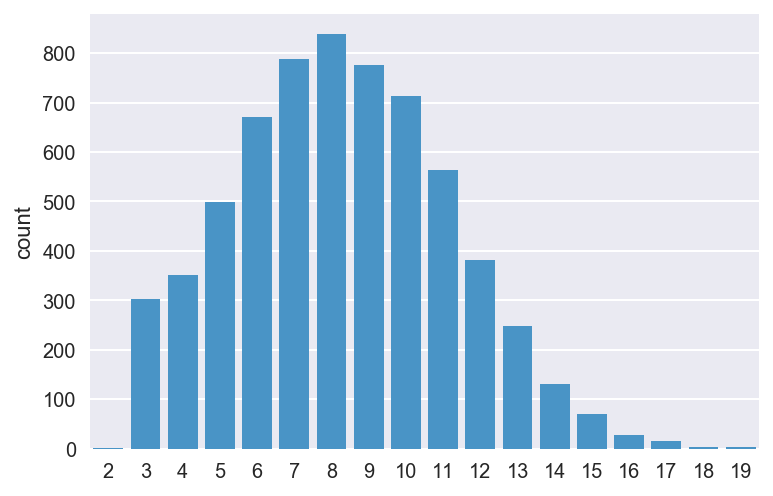

In [15]:
vocab = pd.Series(list(model.wv.vocab.keys()))
sns.countplot(x=vocab.apply(lambda x: len(x)), color="#3498db")

In [60]:
vocab[vocab.apply(lambda x: len(x)>17)]

938      multidisciplinario
997     retroalimentaciones
1759    multidisciplinarios
2167    atendiendoconsultas
2508     telecomunicaciones
5354     carreracolegiatura
5825     telecommunications
dtype: object

In [61]:
model.similarity('contador', 'programador')

0.32822697965126424

In [66]:
model.most_similar('programador')

[('wcf', 0.7098000049591064),
 ('mvc', 0.7018362283706665),
 ('patron', 0.6945970058441162),
 ('cobol', 0.669543445110321),
 ('framework', 0.6338953971862793),
 ('notacion', 0.6322674751281738),
 ('aix', 0.6293807625770569),
 ('angularjs', 0.6270128488540649),
 ('abap', 0.6229496002197266),
 ('hcm', 0.6037029027938843)]

In [71]:
model.most_similar('gerente')

[('jefe', 0.6312872171401978),
 ('aeropuertos', 0.5851298570632935),
 ('payroll', 0.5540546178817749),
 ('coordinador', 0.533851683139801),
 ('director', 0.5335736274719238),
 ('supervisor', 0.5318310260772705),
 ('adjunto', 0.4961100220680237),
 ('gerencia', 0.4952622354030609),
 ('subgerente', 0.4932713508605957),
 ('reunion', 0.4842003583908081)]

In [72]:
model.most_similar('mina')

[('interior', 0.7101279497146606),
 ('largos', 0.6756953001022339),
 ('geologia', 0.6752661466598511),
 ('superficie', 0.6610777378082275),
 ('tajos', 0.6562938690185547),
 ('taladros', 0.6513406038284302),
 ('minas', 0.6504744291305542),
 ('tajo', 0.6485352516174316),
 ('concentradora', 0.6416947841644287),
 ('sostenimiento', 0.640044629573822)]

In [74]:
model.most_similar('javascript')

[('jquery', 0.91120445728302),
 ('css', 0.908501148223877),
 ('html5', 0.9033501744270325),
 ('ajax', 0.8973732590675354),
 ('xml', 0.865014910697937),
 ('css3', 0.8544529676437378),
 ('framework', 0.8456478714942932),
 ('responsive', 0.842521607875824),
 ('asp', 0.8322806358337402),
 ('ide', 0.8164160251617432)]

In [13]:
model.most_similar('egresado')

2017-11-23 00:58:24,050 : INFO : precomputing L2-norms of word weight vectors


[('universitario', 0.7716655731201172),
 ('bachiller', 0.7647414207458496),
 ('recien', 0.7391529083251953),
 ('estudiante', 0.7340214252471924),
 ('apartir', 0.6865410804748535),
 ('titulado', 0.6822622418403625),
 ('ingernieria', 0.6679484248161316),
 ('adealnte', 0.6672634482383728),
 ('10mo', 0.6658382415771484),
 ('egresada', 0.6607942581176758)]

## t-SNE

In [40]:
X = model[vocab]

In [62]:
# X_tsne = TSNE(n_components=2).fit_transform(X)
# np.save('X_tsne', X_tsne)

In [63]:
X_tsne = np.load('X_tsne.npy')

## Kmeans

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
for k in range(10, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X / np.reshape(np.linalg.norm(X, axis=1), (-1,1)))
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    print("For n_clusters =", k, "the average silhouette_score is :", silhouette_avg)

For n_clusters = 10 the average silhouette_score is : 0.00802421
For n_clusters = 11 the average silhouette_score is : 0.0103179
For n_clusters = 12 the average silhouette_score is : 0.011986
For n_clusters = 13 the average silhouette_score is : 0.0114797
For n_clusters = 14 the average silhouette_score is : 0.0106864
For n_clusters = 15 the average silhouette_score is : 0.0107909
For n_clusters = 16 the average silhouette_score is : 0.0107055
For n_clusters = 17 the average silhouette_score is : 0.0125615
For n_clusters = 18 the average silhouette_score is : 0.00975002
For n_clusters = 19 the average silhouette_score is : 0.00826884


In [94]:
n_clusters = 17
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X / np.reshape(np.linalg.norm(X, axis=1), (-1,1)))

In [95]:
df_plot = pd.concat([pd.DataFrame(X_tsne), pd.Series(vocab)], axis=1)
df_plot.columns = ['x', 'y', 'word']
df_plot['cluster'] = kmeans.labels_

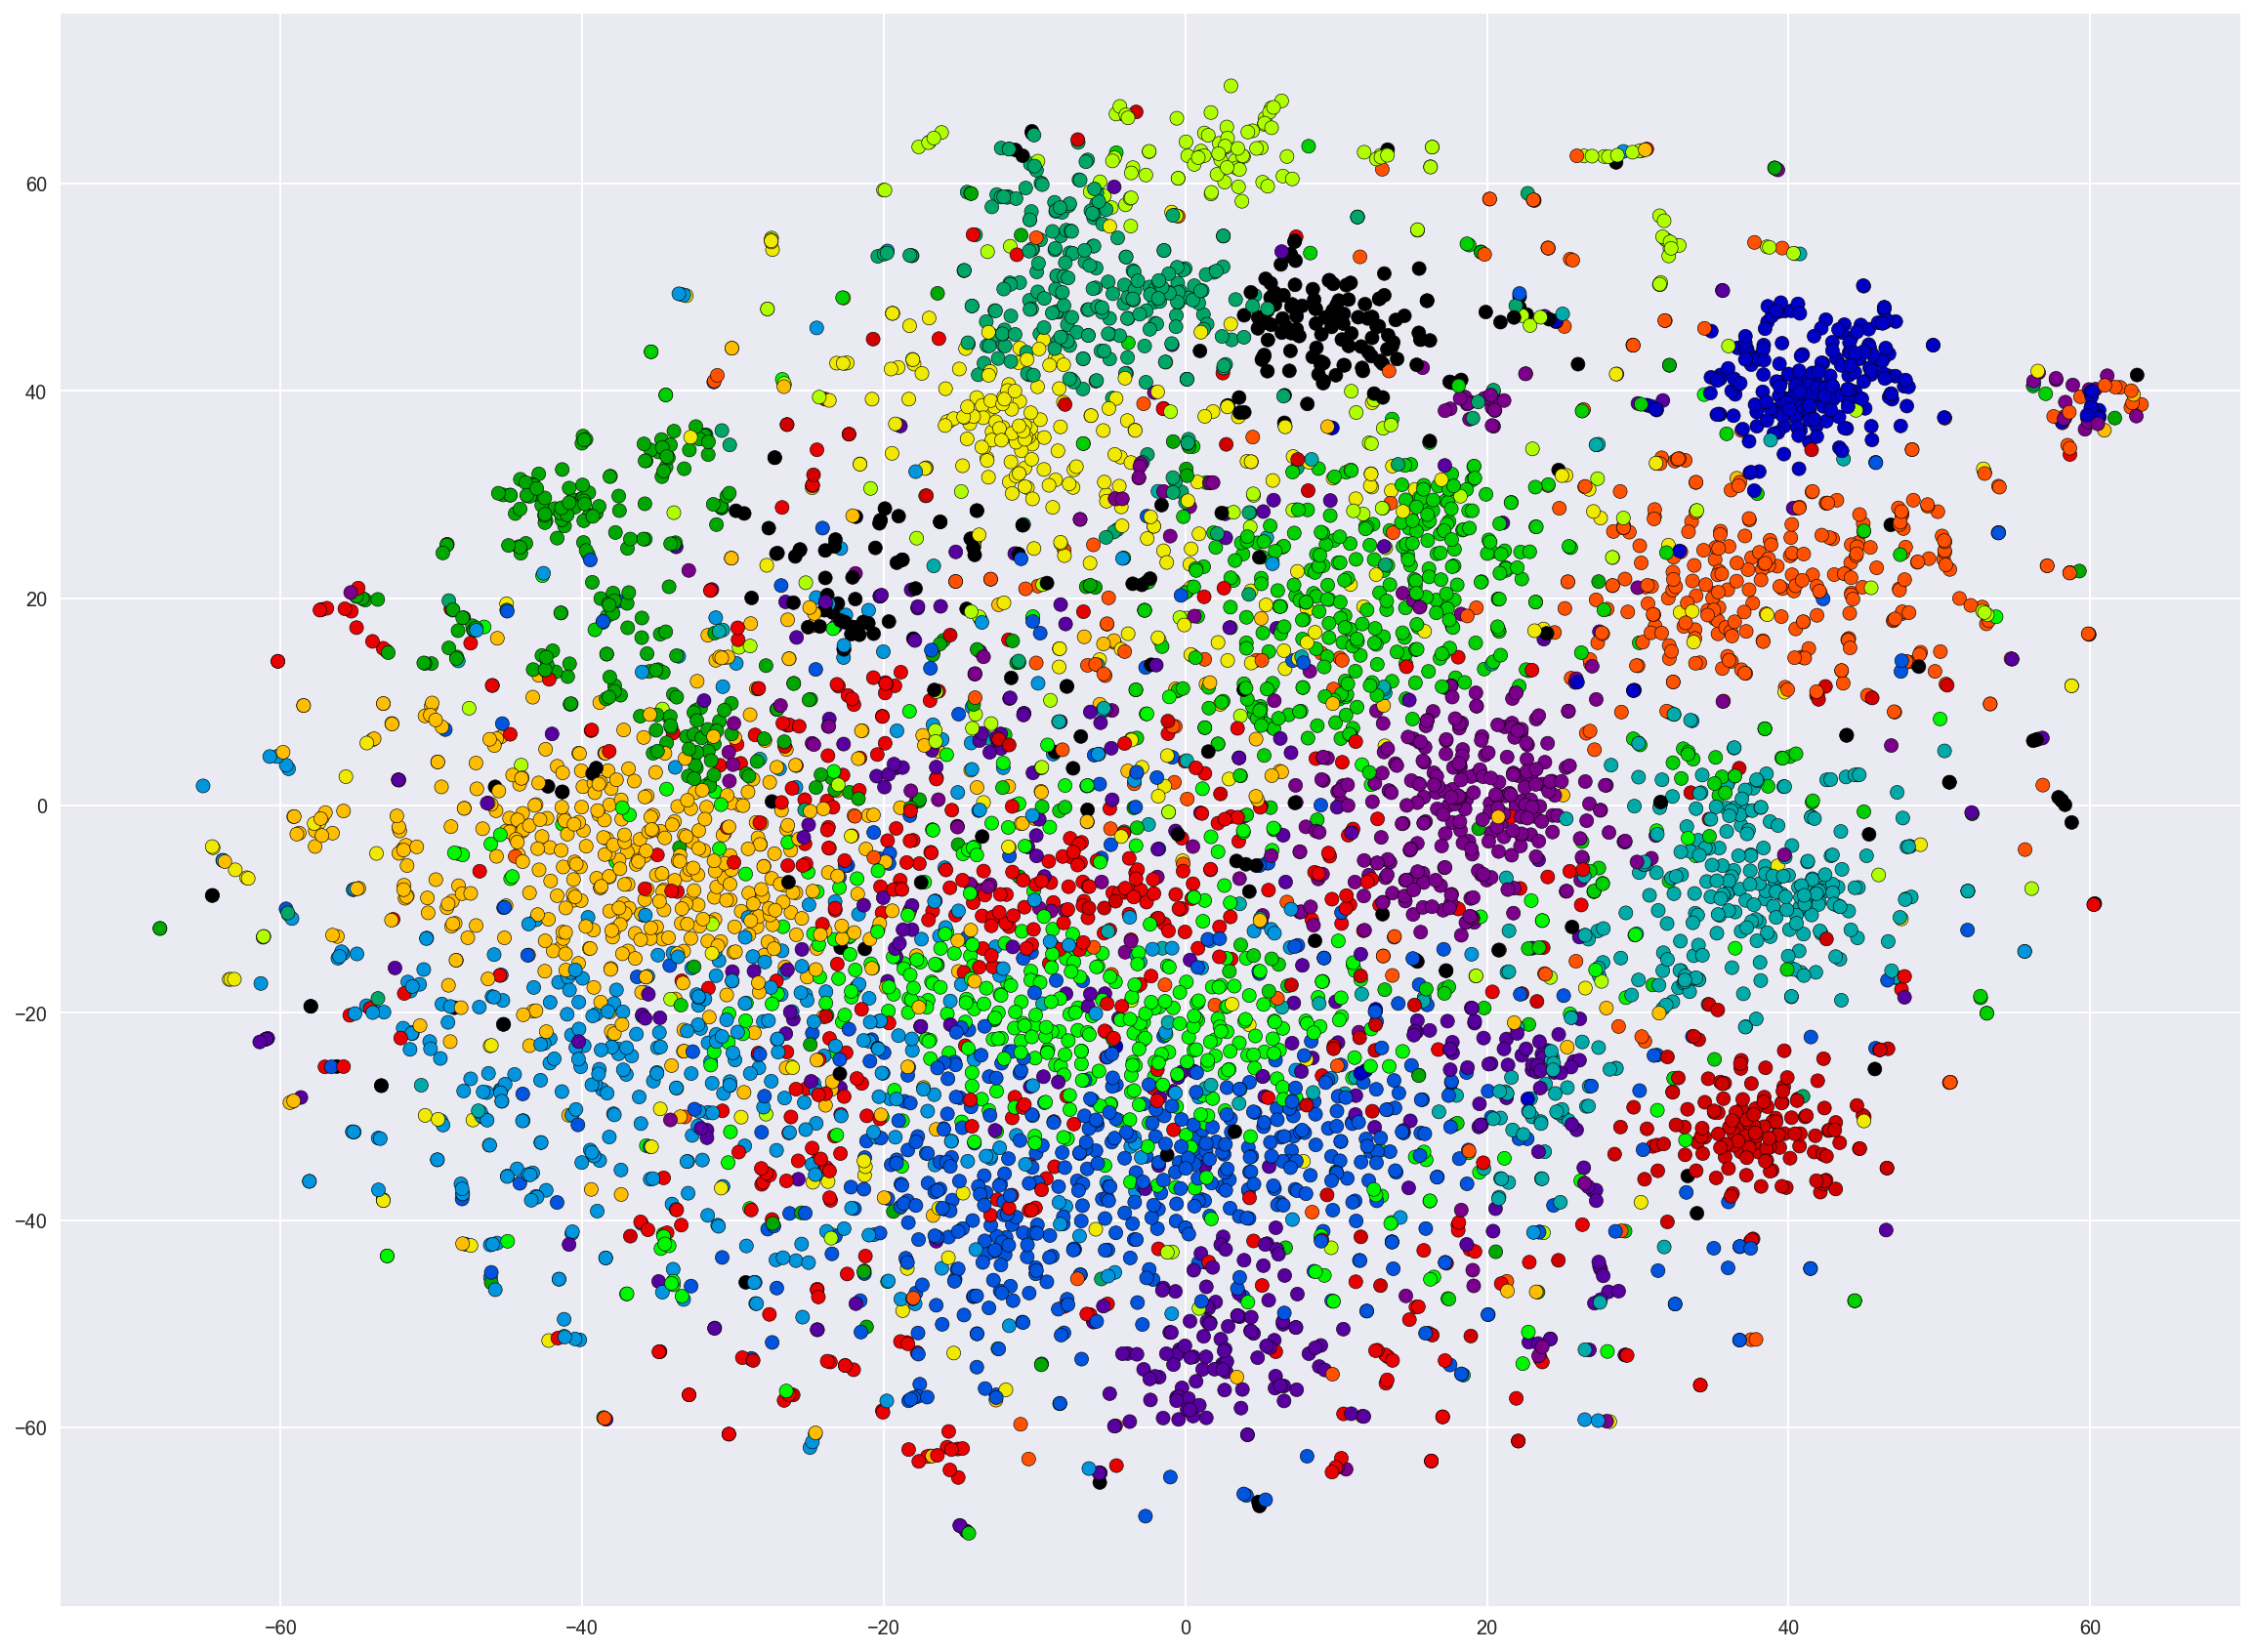

In [96]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(1, 1, 1)
colors = cm.spectral(df_plot['cluster'].astype(float) / n_clusters)
ax.scatter(df_plot['x'], df_plot['y'], marker='.', c=colors, edgecolor='k', s=200)
plt.show()

## Bokeh

In [97]:
colors_hex = list(map(lambda x: '#%02x%02x%02x' % (x[0],x[1], x[2]), (colors*256).astype(int)))

In [98]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Div, BoxZoomTool, \
    ResetTool, PanTool, BoxSelectTool, LabelSet, WheelZoomTool, \
    BoxAnnotation, CustomJS, Toggle
from bokeh.layouts import layout as bl

output_file("word2vec.html", title="Job Description word2vec")
source = ColumnDataSource(df_plot)

2017-11-23 01:21:13,995 : INFO : Session output file 'word2vec.html' already exists, will be overwritten.


In [99]:
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("word", "@word"),
])

tools = [BoxZoomTool(), ResetTool(), PanTool(), BoxSelectTool(), WheelZoomTool()]

p = figure(plot_width=1200, plot_height=550, tools=[hover], title="Word2vec - Job Descriptions")
for tool in tools:
    p.add_tools(tool)
p.circle('x', 'y', size=7, fill_color=colors_hex, source=source)

labels = LabelSet(x='x', y='y', text='word', level='glyph', text_font_size="8pt",
              x_offset=1, y_offset=1, source=source, render_mode='canvas')
labels.visible = False

p.add_layout(labels)

code = '''\
if toggle.active
    labels.visible = true
    console.log 'enabling labels'
else
    labels.visible = false
    console.log 'disabling labels'
'''
callback = CustomJS.from_coffeescript(code=code, args={})
toggle = Toggle(label="Toggle labels", button_type="success", callback=callback)
callback.args = {'toggle': toggle, 'labels': labels}

layout = bl([p], [toggle])

show(layout)

C:\Users\RobertAlonso\Anaconda2\envs\or-tools\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


## DBSCAN

In [108]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import DBSCAN

In [104]:
def cosine(X, Y):
    return 1. / cosine_similarity([X], [Y])[0][0]

In [106]:
cosine(model['javascript'], model['css3'])

1.1703394310369435

In [110]:
cosine_similarity([model['javascript']], [model['css3']])

array([[ 0.85445297]], dtype=float32)

In [109]:
cosine_distances([model['javascript']], [model['css3']])

array([[ 0.14554703]], dtype=float32)

In [211]:
dbscan = DBSCAN(eps=0.35, min_samples=3, metric='cosine').fit(X)

In [212]:
print(np.unique(dbscan.labels_).shape)
len(np.unique(dbscan.labels_))

(59,)


59

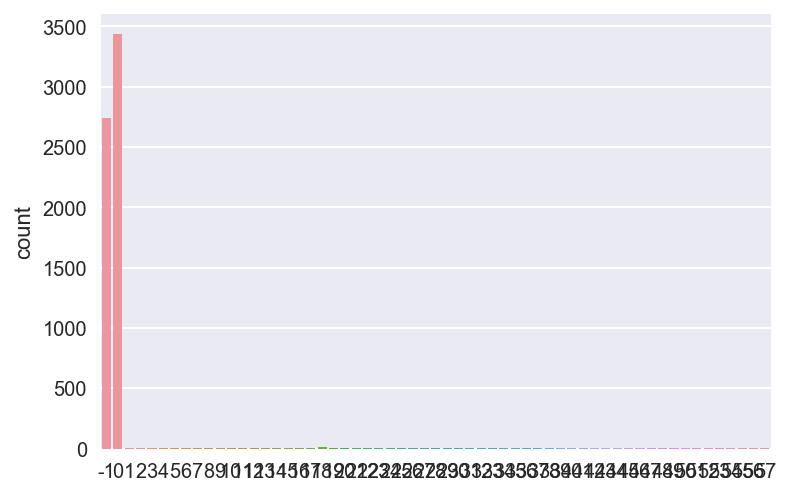

In [213]:
sns.countplot(x=dbscan.labels_)

In [ ]:
df_plot = pd.concat([pd.DataFrame(X_tsne), pd.Series(vocab)], axis=1)
df_plot.columns = ['x', 'y', 'word']
df_plot['cluster'] = dbscan.labels_ + 1

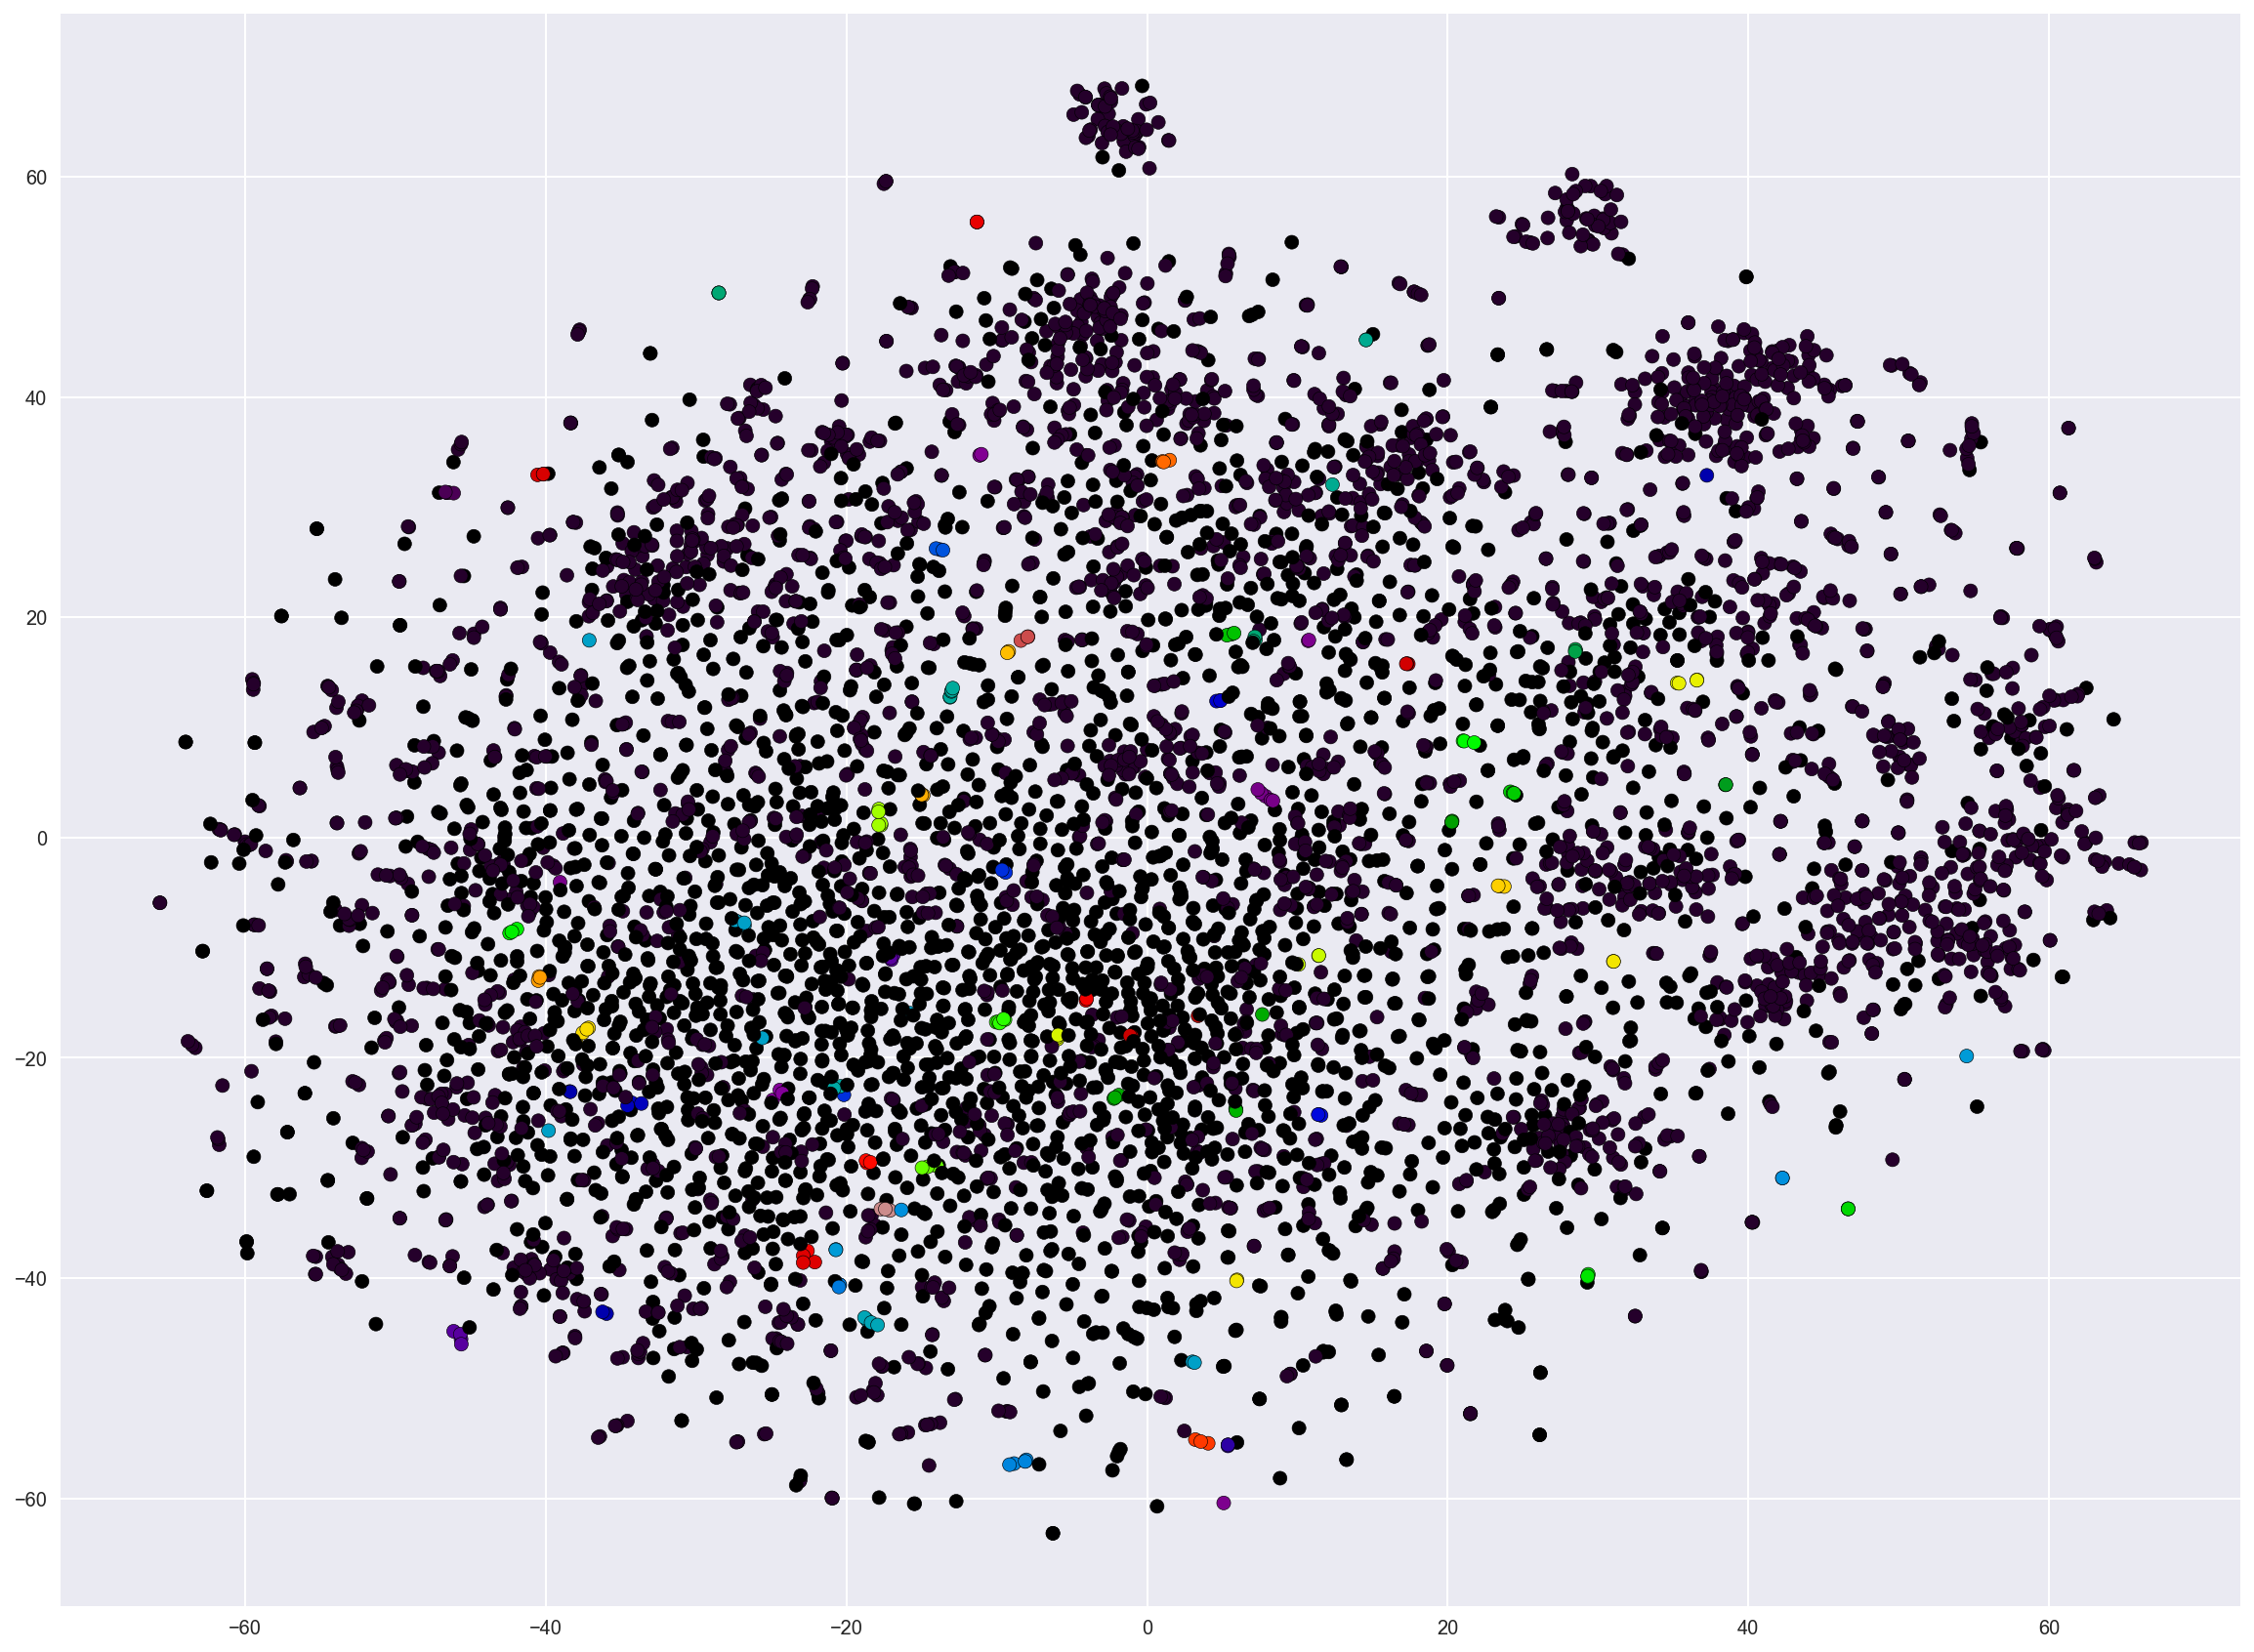

In [215]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(1, 1, 1)
colors = cm.spectral(df_plot['cluster'].astype(float) / len(np.unique(dbscan.labels_)))
ax.scatter(df_plot['x'], df_plot['y'], marker='.', c=colors, edgecolor='k', s=200)
plt.show()